In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# set different font to display korean characters
import matplotlib.font_manager as fm
fprop = fm.FontProperties(family='AppleGothic') # font from matplotlib inbuild

# to ignore plt warnings, not good practice but makes things neat and pretty for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
# set different font to display korean characters; seaborn uses same set as matplotlib
sns.set(style='whitegrid', font='AppleGothic', rc={'figure.figsize':(10,5)})
sns.set_palette(palette='muted')

import nltk

# own utility modules
import mods.text as text
import mods.lyrics as lyrics
import replacements as replacements

# 0. Data Pre-Processing

In [2]:
# read data
raw = pd.read_csv('./data/lyrics.csv', encoding='utf8')
df = raw.copy()

# set column types
df['album_rd'] = df['album_rd'].astype('datetime64[ns]')

# add column to reflect year track is released in df
df['year'] = df['album_rd'].dt.year

# copy of df before filtering
unfiltered_df = df.copy()

# remove album extras (not tracks)
no_skits = df[~df['track_title'].str.contains('notes', case=False) & ~df['track_title'].str.contains('skit', case=False)]

# remove duplicate tracks (non-repackaged, not remix, not short versions)
unique_tracks = no_skits[~no_skits['repackaged'] & ~no_skits['remix'] & ~no_skits['has_full_ver']]

# fill null with "NA"
df = df.fillna('NA')

df.columns
df.describe()

,id,album_seq,year
count,226.000000,226.000000,226.000000
mean,112.500000,7.929204,2016.632743
std,65.384759,5.708032,2.253410
min,0.000000,0.000000,2013.000000
25%,56.250000,4.000000,2015.000000
50%,112.500000,7.000000,2017.000000
75%,168.750000,11.000000,2018.000000
max,225.000000,26.000000,2020.000000


In [3]:
def pre_normalise(text):
    '''
    function to replace text before normalisation
    '''
    replacements = {'ille~gal': 'illegal gal', 'k-pop': 'kpop'}    
    replaced = [replacements[word] if word in replacements.keys() else word for word in text.lower().split()]
    return ' '.join(replaced)
    
df['lyrics'] = df['lyrics'].apply(lambda x: pre_normalise(x))

# expand lyrical contractions
df['lyrics'] = df['lyrics'].apply(lambda x: lyrics.expand_contractions(x))

# normalises lyrics (make text all lowercase, remove punctuation)
to_replace = replacements.replace_list.copy()
to_replace.update(lyrics.CONTRACTIONS)
df['lyrics'] = df['lyrics'].apply(lambda x: text.normalise(x, expand_contractions=True, replacements=to_replace))

# remove adlibs
df['lyrics'] = df['lyrics'].apply(lambda x: lyrics.remove_non_lex_vocables(x))

# do not include tracks that normalises to empty lyrics
df = df[df['lyrics'].str.len() > 0]

df.describe()

,id,album_seq,year
count,219.000000,219.000000,219.000000
mean,113.429224,8.050228,2016.662100
std,64.576874,5.747136,2.228872
min,0.000000,0.000000,2013.000000
25%,59.500000,4.000000,2015.000000
50%,114.000000,7.000000,2017.000000
75%,168.500000,11.000000,2018.000000
max,225.000000,26.000000,2020.000000


In [4]:
from collections import Counter

In [5]:
all_tokens = ' '.join(list(df['lyrics'])).split()
len(all_tokens)

49962

In [6]:
unique_tokens = set(all_tokens)
len(unique_tokens)

4006

In [7]:
top10 = [c[0] for c in Counter(all_tokens).most_common(15)]
top10

['go',
 'like',
 'want',
 'love',
 'know',
 'let',
 'say',
 'get',
 'even',
 'us',
 'one',
 'cannot',
 'day',
 'run',
 'make']

In [8]:
def count_occurrences(word, text):
    return text.lower().split().count(word)

In [9]:
words = df[['id', 'year', 'eng_track_title', 'lyrics']]
# words['love'] = df['lyrics'].apply(lambda l: count_occurrences('love', l))
# words['go'] = df['lyrics'].apply(lambda l: count_occurrences('go', l))
words = words.reset_index()
words['id'] = words.index
words = words.drop(columns='index')
words

,id,year,eng_track_title,lyrics
0,0,2013,Intro: 2 Cool 4 Skool (ft. DJ Friz),go progress step bit difficult ready set begin...
1,1,2013,We Are Bulletproof Pt.2,give nervous one end bulletproof bulletproof b...
2,2,2013,Skit: Circle Room Talk,rap monster big hit v year 2006 rap monster fl...
3,3,2013,No More Dream,dream dream dream dream want big house big car...
4,4,2013,I Like It,want loved want fool want cool want loved love...
...,...,...,...,...
214,214,2020,Skit,jin billboard 1 singer entering j hope call 1 ...
215,215,2020,Telepathy,every time day feel happiest meet every time e...
216,216,2020,Dis-ease,mm look like lost somthing relieve anxiety sip...
217,217,2020,Stay,dream think saw open eye room hold still order...


In [10]:
plt.rcParams["figure.figsize"] = (70,70)
# plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

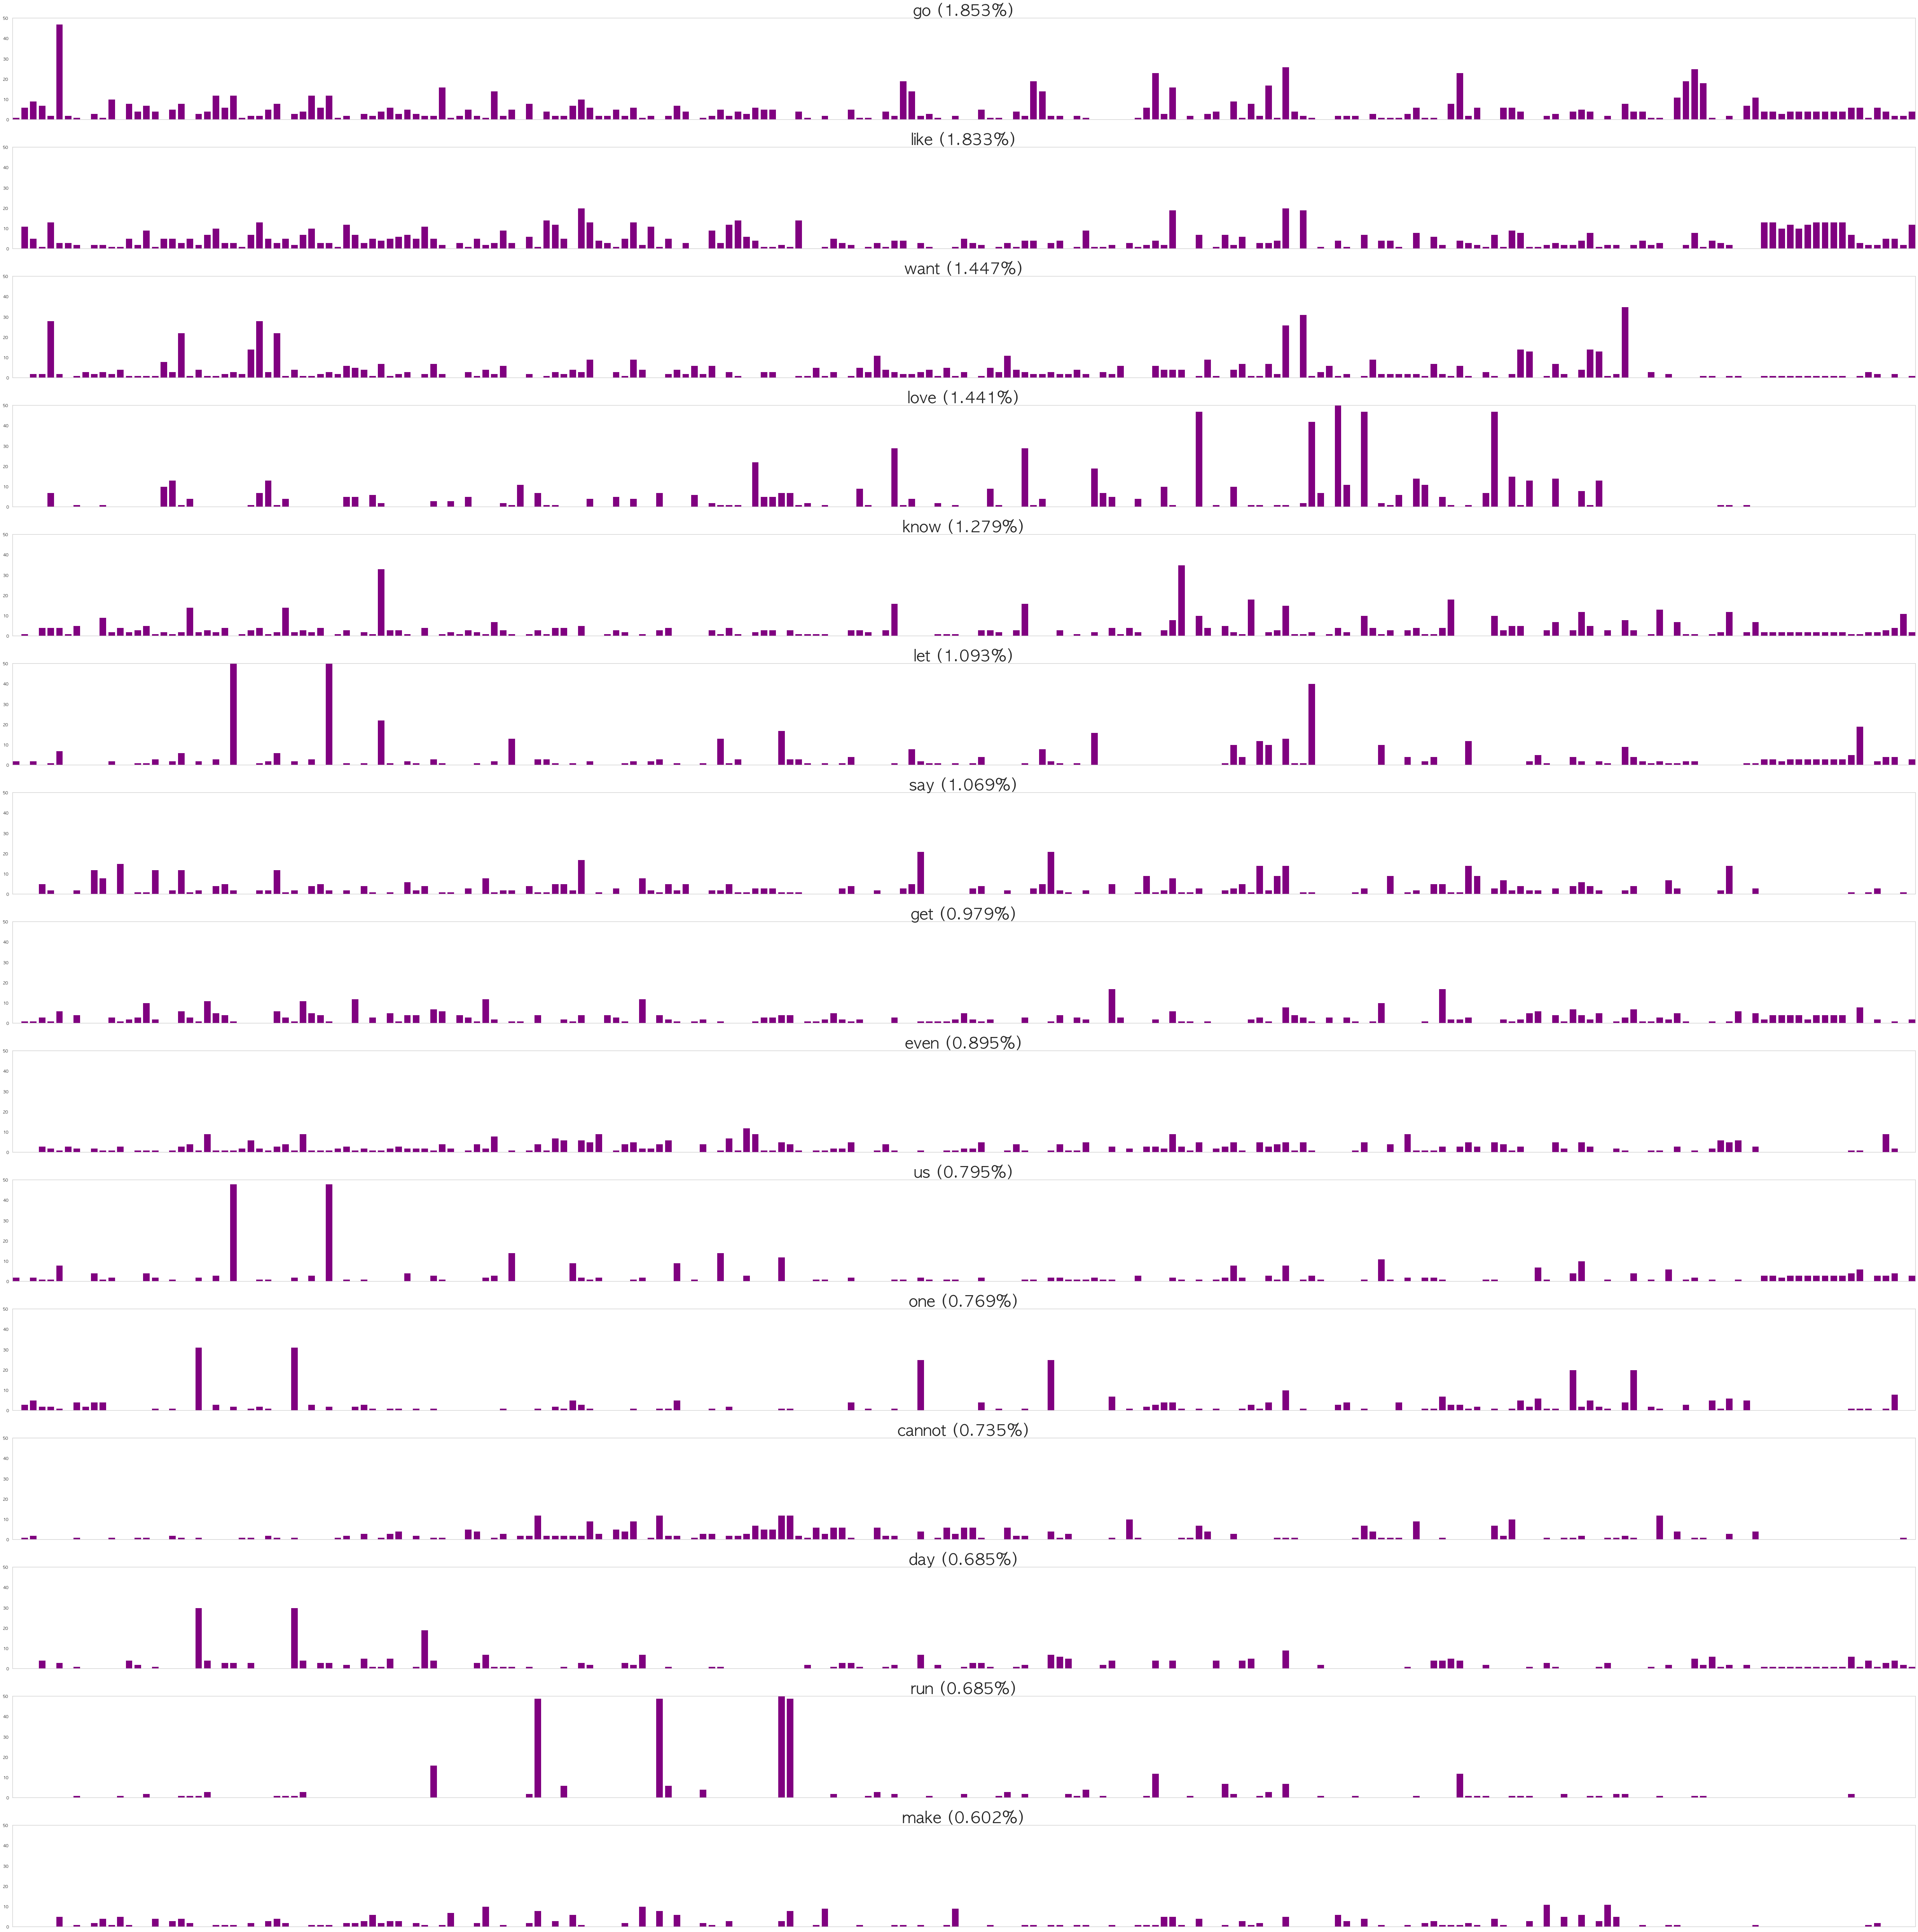

In [30]:
fig, axs = plt.subplots(len(top10))
[a.xaxis.set_visible(False) for a in axs]
# [a.yaxis.set_visible(False) for a in axs]
[a.grid(False) for a in axs]
[a.set_ylim([0,50]) for a in axs]

fig.tight_layout(pad=5)
# plt.axis('scaled')

for i in range(0, len(top10)):
    w = top10[i]
    words[w] = words['lyrics'].apply(lambda l: count_occurrences(w, l))
    try: 
        axs[i].bar(words['id'], words[w], color='purple')
        axs[i].set_title('{} ({:.3%})'.format(w, words[w].sum()/len(all_tokens)), fontdict={'fontsize': 40, 'fontweight': 'medium'})
    except:
        print('error: i={}'.format(i))
# axs[14].bar(words['id'], words['make'], color='purple')
# axs[14].set_title('{} ({:.3%})'.format(w, words['make'].sum()/len(all_tokens)), fontdict={'fontsize': 40, 'fontweight': 'medium'})
fig.savefig('words.png', bbox_inches='tight') 